# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [22]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Вывод**   
Датасет содержит 3214 наблюдений, все переменные приведены к корректным типам.

Проверим данные на мультиколлинеарность факторов. Для этого рассчитаем попарные коэффиценты корреляций.

In [23]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Из таблицы видно, что между переменными calls и minutes существует высокая степень зависимости (коэффициент корреляции по модулю очень близок к 1). Убедимся в прямой зависимости, также построив график.

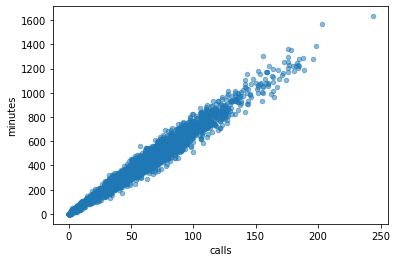

In [25]:
df.plot(kind='scatter', x='calls', y='minutes', alpha=0.5);

Зависимость подтверждается и графически => исключим один из факторов (calls) в дальнейшем анализе.

## Разбейте данные на выборки

Поскольку нет спрятанной тестовой выборки, разделим основную на:
1. Обучающую - 60% наблюдений
2. Валидационную - 20% наблюдений
3. Тестовую - 20% наблюдений

In [26]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

Выделим в каждой выборке target (категорийная переменная с тарифом) и features (набор параметров, представленный остальными переменными)

In [27]:
df_train_target = df_train['is_ultra']
df_train_features = df_train.drop(['is_ultra','calls'], axis=1)

df_valid_target = df_valid['is_ultra']
df_valid_features = df_valid.drop(['is_ultra','calls'], axis=1)

df_test_target = df_test['is_ultra']
df_test_features = df_test.drop(['is_ultra','calls'], axis=1)

## Исследуйте модели

Для задачи классификации оценим 3 типа моделей:
1. Решающее дерево (с глубиной от 2 до 10)
2. Случайный лес (с глубиной от 2 до 10, количеством независимых деревьев от 2 до 10)
3. Логистическая регрессия

### Решающее дерево

In [28]:
best_depth_tree = 0
best_accuracy_tree = 0

for depth in range(2, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(df_train_features, df_train_target)
    prediction = model.predict(df_valid_features)
    accuracy = accuracy_score(prediction, df_valid_target)
    if accuracy > best_accuracy_tree:
        best_depth_tree = depth
        best_accuracy_tree = accuracy

print(f'Лучшая глубина - {best_depth_tree}. Лучшая точность - {best_accuracy_tree:.3f}')

Лучшая глубина - 4. Лучшая точность - 0.788


### Случайный лес

In [29]:
best_depth_forest = 0
best_estimator_forest = 0
best_accuracy_forest = 0

for depth in range(2, 11):
    for estimator in range(2,11):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators = estimator)
        model.fit(df_train_features, df_train_target)
        prediction = model.predict(df_valid_features)
        accuracy = accuracy_score(prediction, df_valid_target)
        if accuracy > best_accuracy_forest:
            best_depth_forest = depth
            best_estimator_forest = estimator
            best_accuracy_forest = accuracy

print(f'Лучшая глубина - {best_depth_forest}, количество деревьев - {best_estimator_forest}. Лучшая точность - {best_accuracy_forest:.3f}')

Лучшая глубина - 7, количество деревьев - 9. Лучшая точность - 0.796


### Логистическая регрессия

In [30]:
model = LogisticRegression()
model.fit(df_train_features, df_train_target)
prediction = model.predict(df_valid_features)
accuracy = accuracy_score(prediction, df_valid_target)
print(f'Точность - {accuracy:.3f}')

Точность - 0.708


**Вывод**   
На валидационной выборке наилучшие результаты показала модель случайного леса с 9 деревьями и глубиной равной 7. Проверим ее качество на тестовой выборке.

## Проверьте модель на тестовой выборке

In [31]:
model = RandomForestClassifier(random_state=12345, max_depth=best_depth_forest, n_estimators = best_estimator_forest)
model.fit(df_train_features, df_train_target)
prediction = model.predict(df_test_features)
accuracy = accuracy_score(prediction, df_test_target)
print(f'Точность модели составила - {accuracy:.3f}')

Точность модели составила - 0.804


**Вывод**   
Точность по-прежнему выше 0.75 => можно остановиться на данной модели.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
